# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
# Enable inline plotting
%matplotlib inline

# Backport python3 division behavior
from __future__ import division

from urllib import urlencode
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import os

import pytz
from pprint import pprint

from sklearn.linear_model import LinearRegression
import seaborn as sns

# Set plotting configuration
sns.set_palette('deep', desat=.8)
sns.set_context('notebook', font_scale=1.5, rc={'figure.figsize': (16,5)})
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)

import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

In [2]:
import pvlib
import rdtools

print pvlib.__version__
print rdtools.__version__

0.4.4
1.0.1+28.gaf57155


/Users/traveler/anaconda/envs/python2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. <b>Standardize</b>

Please download the annual csv data for system with system id 4, using the PVDAQ API, and store the csv file in the folder:
./rdtools/docs/

https://developer.nrel.gov/docs/solar/pvdaq-v3/data_file/

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



In [3]:
systemid=4
api_key='ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'
pvdaq_metadata_url = 'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=' + str(systemid) + '&api_key=' + api_key

In [4]:
pvdaq_metadata_url

'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=4&api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'

In [5]:
import urllib2
import xmltodict
import xml.etree.ElementTree as et

file = urllib2.urlopen(pvdaq_metadata_url)
tree = et.parse(file)
file.close()

root = tree.getroot()



avail_year = [int(avail_year.text) for avail_year in root.iter('available-year')]
start_year = avail_year[0]
end_year = avail_year[-1]
inverter_mfg = [str(inv_mfg.text) for inv_mfg in root.iter('inverter-mfg')][0]
inverter_model = [str(inv_model.text) for inv_model in root.iter('inverter-model')][0]
module_mfg = [str(mod_mfg.text) for mod_mfg in root.iter('module-mfg')][0]
module_model = [str(mod_model.text) for mod_model in root.iter('module-model')][0]
power = [float(site_power.text) for site_power in root.iter('site-power')][0]
area = [float(site_area.text) for site_area in root.iter('site-area')][0]
azimuth = [float(site_azimuth.text) for site_azimuth in root.iter('site-azimuth')][0]
elevation = [float(site_elevation.text) for site_elevation in root.iter('site-elevation')][0]
lat = [float(site_lat.text) for site_lat in root.iter('site-latitude')][0]
lon = [float(site_lon.text) for site_lon in root.iter('site-longitude')][0]
lon = -lon
tilt = [float(site_tilt.text) for site_tilt in root.iter('site-tilt')][0]
name = [str(name_priv.text) for name_priv in root.iter('name-private')][0]

In [6]:
avail_year

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [7]:
year = 2012
pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)

In [8]:
pvdaq_ann_csv_url

'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd&system_id=4&year=2012'

In [9]:
df = pd.DataFrame()
#list_years = avail_year
list_years = [2011,2012,2013,2014]
for year in list_years:
    pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)
    data = pd.read_csv(pvdaq_ann_csv_url)
    df = df.append(data)
    

In [10]:
df.head()

,SiteID,Date-Time,ac_current,ac_power,ac_voltage,ambient_temp,das_battery_voltage,das_temp,dc_pos_current,dc_pos_voltage,dc_power,inverter_temp,module_temp_1,module_temp_2,module_temp_3,poa_irradiance,power_factor
0,4,2011-01-01 00:00:00,0.1852,3.5983,122.7243,-11.7481,14.2073,-12.6825,-0.0201,2.0320,-0.0410,-13.1481,-13.5912,-13.6024,-13.5606,-2.1791,0.1127
1,4,2011-01-01 00:01:00,0.1839,3.5768,122.7654,-11.8722,14.2068,-12.6701,-0.0155,1.7694,-0.0256,-13.1402,-13.6533,-13.6436,-13.6264,-2.1185,0.1134
2,4,2011-01-01 00:02:00,0.1850,3.5121,122.7740,-11.8864,14.2068,-12.6701,-0.0183,2.0377,-0.0367,-13.1469,-13.6197,-13.5445,-13.5668,-2.1791,0.1131
3,4,2011-01-01 00:03:00,0.1846,3.4475,122.8390,-11.6923,14.2073,-12.6513,-0.0171,1.8436,-0.0302,-13.1250,-13.4601,-13.3968,-13.3640,-2.1185,0.1127
4,4,2011-01-01 00:04:00,0.1846,3.5983,122.8459,-11.6095,14.2064,-12.6475,-0.0110,1.9463,-0.0207,-13.1205,-13.3662,-13.4004,-13.3014,-2.0580,0.1131


In [11]:
type(df['Date-Time'])

pandas.core.series.Series

In [12]:
df['Date-Time'] = pd.to_datetime(df['Date-Time'])

In [13]:
df.set_index('Date-Time', inplace=True)

In [14]:
df.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 00:01:00',
               '2011-01-01 00:02:00', '2011-01-01 00:03:00',
               '2011-01-01 00:04:00', '2011-01-01 00:05:00',
               '2011-01-01 00:06:00', '2011-01-01 00:07:00',
               '2011-01-01 00:08:00', '2011-01-01 00:09:00',
               ...
               '2014-03-21 03:23:00', '2014-03-21 03:24:00',
               '2014-03-21 03:25:00', '2014-03-21 03:26:00',
               '2014-03-21 03:27:00', '2014-03-21 03:28:00',
               '2014-03-21 03:29:00', '2014-03-21 03:30:00',
               '2014-03-21 03:31:00', '2014-03-21 03:32:00'],
              dtype='datetime64[ns]', name=u'Date-Time', length=336190, freq=None)

In [15]:
df = df.resample('T').mean()

In [16]:
print pd.infer_freq(df.index)

T


In [17]:
timezone = pytz.timezone("Etc/GMT+7")
df.index = df.index.tz_localize(timezone)

In [18]:
module_temp = df.filter(regex=("module_temp*"))
module_temp = module_temp.median(axis=1)
df['module_temperature'] = module_temp

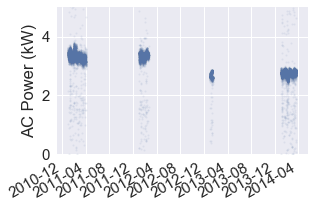

In [19]:
# downsample
df = df.asfreq('15T') 

# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df.ac_power, 'o', alpha = 0.1)
ax.set_ylim(0,5)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (kW)');

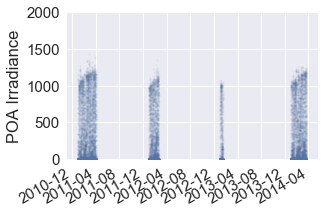

In [20]:
# plot the POA irradiance time series
fig, ax = plt.subplots()
ax.plot(df.index, df.poa_irradiance, 'o', alpha = 0.1)
ax.set_ylim(0,2000)
fig.autofmt_xdate()
ax.set_ylabel('POA Irradiance');

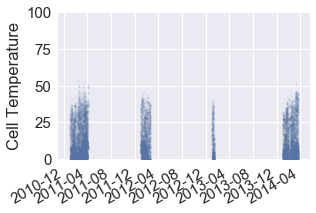

In [21]:
# plot the cell temperature time series
fig, ax = plt.subplots()
ax.plot(df.index, df.module_temperature, 'o', alpha = 0.1)
ax.set_ylim(0,100)
fig.autofmt_xdate()
ax.set_ylabel('Cell Temperature');

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

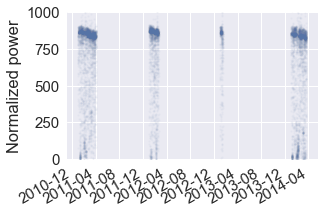

In [22]:
# Metadata
pdc = 1.0 # System size in kW

pvwatts_kws = {"poa_global" : df.poa_irradiance,
              "P_ref" : pdc,
              "T_cell" : df.module_temperature,
              "G_ref" : 1000,
              "T_ref" : 20,
              "gamma_pdc" : -0.0029}

normalized = rdtools.normalize_with_pvwatts(df.ac_power, pvwatts_kws)


# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,1000)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [23]:
normalized.head(n=50)

Date-Time
2011-01-01 00:00:00-07:00   -1504.698617
2011-01-01 00:15:00-07:00   -1399.905533
2011-01-01 00:30:00-07:00   -1548.526013
2011-01-01 00:45:00-07:00   -1774.385985
2011-01-01 01:00:00-07:00   -1502.471348
2011-01-01 01:15:00-07:00   -1683.274159
2011-01-01 01:30:00-07:00   -1790.714535
2011-01-01 01:45:00-07:00   -1536.679821
2011-01-01 02:00:00-07:00   -1694.959525
2011-01-01 02:15:00-07:00   -1478.935894
2011-01-01 02:30:00-07:00   -1471.036130
2011-01-01 02:45:00-07:00   -1509.812758
2011-01-01 03:00:00-07:00   -1480.497451
2011-01-01 03:15:00-07:00   -1499.083521
2011-01-01 03:30:00-07:00   -1486.278273
2011-01-01 03:45:00-07:00   -1647.510748
2011-01-01 04:00:00-07:00   -1432.854622
2011-01-01 04:15:00-07:00   -1455.608753
2011-01-01 04:30:00-07:00   -1378.472934
2011-01-01 04:45:00-07:00   -1532.952682
2011-01-01 05:00:00-07:00   -1589.727543
2011-01-01 05:15:00-07:00   -1516.906617
2011-01-01 05:30:00-07:00   -1493.002637
2011-01-01 05:45:00-07:00   -1426.232028
2011-0

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


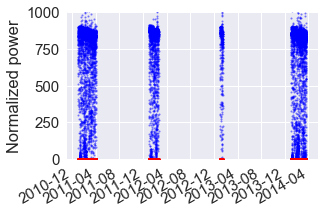

In [24]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future

df['normalized'] = normalized
#filter_criteria = ((df['normalized']>0) & (df['normalized']<2) & (df.poa_irradiance>200))
filter_criteria = ((df['normalized']>750) & (df['normalized']<1000) & (df.poa_irradiance>200))

filtered = df[filter_criteria]['normalized']




#after filtering, center the data at PR_t0 = 1
def center_data(series):
    v = series.resample('12M').median().max()    
    return series / v

filtered = center_data(filtered)


# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', color='b', alpha = 0.5)
ax.plot(filtered.index, filtered, 'o', color='r', alpha = 0.5)
ax.set_ylim(0,1000)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [25]:
filtered

Date-Time
2011-01-01 11:15:00-07:00    0.947733
2011-01-01 11:30:00-07:00    0.936397
2011-01-01 11:45:00-07:00    0.938342
2011-01-01 12:00:00-07:00    0.967877
2011-01-01 12:15:00-07:00    1.004204
2011-01-01 12:30:00-07:00    0.970362
2011-01-01 12:45:00-07:00    1.018818
2011-01-01 13:00:00-07:00    0.980201
2011-01-01 14:00:00-07:00    0.979114
2011-01-01 14:15:00-07:00    0.942412
2011-01-01 14:45:00-07:00    0.958806
2011-01-01 15:00:00-07:00    0.907412
2011-01-01 16:00:00-07:00    0.950669
2011-01-02 09:30:00-07:00    0.929476
2011-01-02 09:45:00-07:00    0.956395
2011-01-02 10:00:00-07:00    0.970819
2011-01-02 10:15:00-07:00    0.972717
2011-01-02 10:30:00-07:00    0.987431
2011-01-02 10:45:00-07:00    0.998031
2011-01-02 11:00:00-07:00    0.933725
2011-01-02 11:15:00-07:00    0.916674
2011-01-02 11:30:00-07:00    0.969729
2011-01-02 11:45:00-07:00    0.988404
2011-01-02 12:00:00-07:00    0.970323
2011-01-02 12:15:00-07:00    0.973119
2011-01-02 12:30:00-07:00    0.981069
20

# 4. <b>Analyze</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.  The data may or may not be aggregated by this step.  



In [26]:
ols_rd, ols_ci, ols_info = rdtools.degradation.degradation_ols(filtered)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year''' % (ols_rd, ols_ci[0], ols_ci[1])

# yoy = rdtools.degradation.degradation_year_on_year(filtered)
# print "degradation_year_on_year", yoy

The degradation rate calculated with ols is -0.19 %/year
with a confidence interval of -0.23 to -0.15 %/year


In [27]:
filtered.index

DatetimeIndex(['2011-01-01 11:15:00-07:00', '2011-01-01 11:30:00-07:00',
               '2011-01-01 11:45:00-07:00', '2011-01-01 12:00:00-07:00',
               '2011-01-01 12:15:00-07:00', '2011-01-01 12:30:00-07:00',
               '2011-01-01 12:45:00-07:00', '2011-01-01 13:00:00-07:00',
               '2011-01-01 14:00:00-07:00', '2011-01-01 14:15:00-07:00',
               ...
               '2014-03-20 14:45:00-07:00', '2014-03-20 15:00:00-07:00',
               '2014-03-20 15:15:00-07:00', '2014-03-20 15:30:00-07:00',
               '2014-03-20 15:45:00-07:00', '2014-03-20 16:00:00-07:00',
               '2014-03-20 16:15:00-07:00', '2014-03-20 16:30:00-07:00',
               '2014-03-20 16:45:00-07:00', '2014-03-20 17:00:00-07:00'],
              dtype='datetime64[ns, Etc/GMT+7]', name=u'Date-Time', length=5689, freq=None)

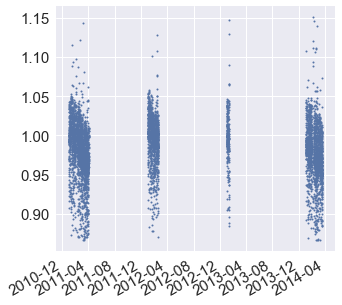

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(filtered.index, filtered, 'o', alpha = 1.0)
fig.autofmt_xdate()

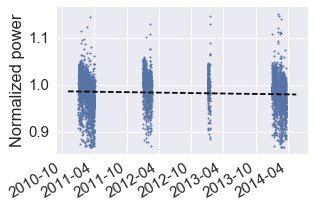

In [29]:
# plot the regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(filtered.index, filtered, 'o', alpha = 1.0)
x_vals = np.array(ax.get_xlim())
y_vals = ols_info['intercept'] + ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')

#ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [30]:
# Plot the year-on-year distribution
# YoY_filtered1 = yoy['YoY_filtered']
# YOY_median = yoy['Rd_median']
# plt.hist(YoY_filtered1, alpha=0.5, label='YOY', bins=int(YoY_filtered1.__len__()/4))
# plt.axvline(x=YOY_median, color='black', linestyle='dashed', linewidth=3)
# #plt.legend(loc='upper right')
# plt.title('Year-on-Year 15-minute Distribution \n Data outside +/-100 removed')   
# plt.tight_layout(w_pad=1, h_pad=2.0)
# plt.xlabel('Annual degradation (%)')